# Video Classification with Transformers

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [1]:
import tensorflow as tf

tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
pip install matplotlib

In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
 pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [6]:
 pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [8]:
print(tf.__version__)

2.5.0


## Define hyperparameters

In [3]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## Data preparation

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
validation_df = pd.read_csv("validation.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")
print(f"Total videos for validation: {len(validation_df)}")

train_df.sample(10)

Total videos for training: 2549
Total videos for testing: 374
Total videos for validation: 373


,video_name,tag
1632,nonViolent/v_Bowling_g04_c02.avi,nonViolent
159,blood and gore/Horror Movie Death Compilation ...,blood and gore
2532,Violence fights/Top 6 high school satisfy fig...,Violence fights
1793,Sport fights/v_Punch_g07_c04.avi,Sport fights
2196,Torturing and bulling/MEDIAEVAL16_01158.mp4,Torturing and bulling
1975,Torturing and bulling/ACCEDE03123.mp4,Torturing and bulling
862,coldarms/vlc-record-2018-08-06-23h07m10s-bE39-...,coldarms
2393,Violence fights/Most Brutal Fight Scene Ever ...,Violence fights
120,blood and gore/Horror bloody death scene new 2...,blood and gore
2430,Violence fights/Nobody (2021) - Bus Fight Scen...,Violence fights


In [5]:
center_crop_layer = layers.experimental.preprocessing.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [6]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [11]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
_________________________________________________________________


In [9]:
# Label preprocessing with StringLookup.
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


['Sport fights', 'Torturing and bulling', 'Violence fights', 'blood and gore', 'carchase', 'coldarms', 'explosions', 'firearms', 'nonViolent']


In [7]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    print(num_samples)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        
        if len(frames) == 0 : 
            continue
        
        print(idx)
        
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))
        
            
#         frames = frames[None, ...]
   

        # Initialize placeholder to store the features of the current video.
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[1]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_featutes[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_featutes[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_featutes.squeeze()

    return frame_features, labels

In [10]:
train_data, train_labels = prepare_all_videos(train_df, "split/train")
test_data, test_labels = prepare_all_videos(test_df, "split/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

2549
0
1
2
3
4
5
6


KeyboardInterrupt: 

In [ ]:
from numpy import save

save('train_data.npy', train_data)
save('train_labels.npy', train_labels)
save('test_data.npy', test_data)
save('test_labels.npy', test_labels)

## Building the Transformer-based model

In [72]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [73]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [79]:
from matplotlib import pyplot

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
#     filepath = "/tmp/video_classifier"
#     checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath, save_weights_only=True, save_best_only=True, verbose=1
#     )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
    )
    
    #model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
     # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Root Mean Squared Error')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()

    return model

## Model training and inference

Epoch 1/5
68/68 [==============================] - 3s 22ms/step - loss: 2.9346 - accuracy: 0.2359 - val_loss: 8.8382 - val_accuracy: 0.0783
Epoch 2/5
68/68 [==============================] - 1s 13ms/step - loss: 1.7144 - accuracy: 0.4705 - val_loss: 8.7590 - val_accuracy: 0.0261
Epoch 3/5
68/68 [==============================] - 1s 11ms/step - loss: 1.3496 - accuracy: 0.5591 - val_loss: 9.2408 - val_accuracy: 0.0339
Epoch 4/5
68/68 [==============================] - 1s 11ms/step - loss: 1.1487 - accuracy: 0.6108 - val_loss: 9.5453 - val_accuracy: 0.0418
Epoch 5/5
12/12 [==============================] - 0s 6ms/step - loss: 2.5555 - accuracy: 0.5053
Test accuracy: 50.53%


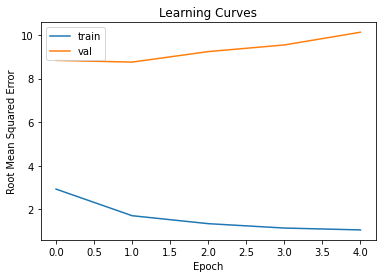

In [100]:
trained_model = run_experiment()

Test video path: firearms/Top 10 Gun Fights in Movies - 047.mp4
  firearms: 53.63%
  explosions: 17.78%
  blood and gore: 15.86%
  coldarms:  6.18%
  Torturing and bulling:  3.79%
  carchase:  2.75%
  nonViolent:  0.02%
  Violence fights:  0.00%
  Sport fights:  0.00%



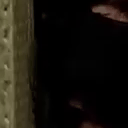

In [115]:

def prepare_single_video(frames):
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_featutes[i, j, :] = 0.0

    return frame_featutes


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("split/test/", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])